# Курсовой проект
## Двухуровневая рекомендательная система

Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

# стандартизация
from sklearn.preprocessing import StandardScaler

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k as pk, recall_at_k as rk
from src.utils import prefilter_items
from src.recommenders import MainRecommender

- **Чтение данных**
- **Создание 4 выборок**:
    - для выбора 50 лучших кандидатов
    - для оценка качества выборки
    - для выбора рекомендованных товаров
    - для проверки качества рекомендаций

In [2]:
# читаем данные
data = pd.read_csv('retail_train.csv')
# информация о продуктах
item_features = pd.read_csv('product.csv')
# информация о пользователях
user_features = pd.read_csv('hh_demographic.csv')

# column processing - преобразование названий колонок; в данном случае ничего не изменяется
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]
# изменение названий колонок
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# выбор количества недель между временем окончания наполнения данными БД и двумя частями (1 - для первой части, т.е. для отбора товаров-кандидатов; 2 - для второй, т.е. для выбора лучших кандидатов)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3
# создание датафреймов: для изучения и отбора кандидатов - data_train_lvl_1
# для проверки правильности (по recall и precision): data_val_lvl_1
# для обучения модели, отбирающих лучших кандидатов: data_train_lvl_2
# для проверки точности модели (по precision@k): data_val_lvl_2
data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


**работа с первой выборкой: отсев "очень часто" и "очень редко" покупаемых товаров**

In [3]:
# для начала работы необходимо отсеять совсем очевидные (очень часто покупаемые) товары, которые и так часто покупают - их нет смысла рекомендовать;
# также необходимо отсеять очень редко покупаемые товары, которые или просто не пользуются спросом (плохие) или сами по себе хорошие, но при этом очень специфичные:
# их рекомендовать нет смысла, т.к. затраты на "уговоры" покупателей их купить будут дороже, чем в случае других, более "хороших" товаров-кандидатов
# из оставшихся товаров берем 5000 самых популярных; из них и будем выбирать те, которые стоит порекомендовать каждому пользователю из последней выборки data_val_lvl_2

# код ниже - проверка количества товаров до подобной фильтрации и после
n_items_before = data_train_lvl_1['item_id'].nunique()
data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)
n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


**добавление новых расчетных полей**:
- цена товара - просто пересчет пересчет + заполнение нулями полей Nan или np.inf
- квантиль номера недели (квантиль подбирался отдельно, по графикам распределения; для другой выборки нужно подбирать заново; поэтому просто сохранены эмпирические значения)
- квантиль количества купленных товаров (аналогичный подход)
- квантиль цены (квартили)
- квантиль времени транзакции (квартили)
- цена товара с учетом скидки

In [4]:
data_train_lvl_1['price'] = data_train_lvl_1['sales_value'] / data_train_lvl_1['quantity']
data_train_lvl_1['price'].fillna(0)
data_train_lvl_1['price'] = data_train_lvl_1['price'].replace([np.inf, -np.inf], 0)
data_train_lvl_1['price_disc'] = data_train_lvl_1['price']-data_train_lvl_1['retail_disc']*data_train_lvl_1['price']
data_train_lvl_1['week_no_q'] = pd.cut(data_train_lvl_1.week_no,bins=data_train_lvl_1.week_no.quantile([0,0.25,0.5,0.75,1]).values,labels=[1,2,3,4]).fillna(1)
data_train_lvl_1['price_q'] = pd.cut(data_train_lvl_1.price,bins=data_train_lvl_1.price.quantile([0,0.25,0.5,0.75,1]).values,labels=[1,2,3,4]).fillna(1)
data_train_lvl_1['trans_time_q'] = pd.cut(data_train_lvl_1.trans_time,bins=data_train_lvl_1.trans_time.quantile([0,0.25,0.5,0.75,1]).values,labels=[1,2,3,4]).fillna(1)
data_train_lvl_1['quantity_q'] = pd.cut(data_train_lvl_1['quantity'],bins = data_train_lvl_1['quantity'].quantile([0,0.8,0.9,0.985,1]),labels=[1,2,3,4])

**проведение анализа по пользователям, купившим более N товаров**
- данный подход не сработал, поэтому не применяется;
- использованы различные N от 0 до 50.

**проведение анализа по пользователям, купившим менее N товаров**
- данный подход не сработал, поэтому не применяется;
- использованы различные N от 150 до 1000.

**Через recommender можно обращаться к четырем методам рекомендации: als, own_recommender, similar_items и similar_users**

In [5]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [6]:
# в этой части кода создается датафрейм с данными о купленных товарах по каждому пользователю
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


**Для расчета метрик recall@k и precision@k будут использованы данные функции**

In [7]:
# для получения оценки recall@k и precision@k используется средняя оценка recall и precision по всем пользователям (рассчитывается для каждого и берется среднее)
def recall_at_k(recommended_list, bought_list, k=200):
    recall = sum([sum(np.isin(list(set(i)), ii[:k])) / len(i) if len(i)<=len(ii) else sum(np.isin(ii[:k],list(set(i)))) / len(i) for i,ii in zip(bought_list,recommended_list)]) / len(bought_list)
    return recall*100

def precision_at_k(recommended_list, bought_list, k=200):
    precision = sum([sum(np.isin(list(set(i)), ii[:k])) / k if len(i)<=len(ii) else sum(np.isin(ii[:k],list(set(i)))) / k for i,ii in zip(bought_list,recommended_list)]) / len(recommended_list)
    return precision*100

**1. Проверка качества ALS-рекомендаций**

In [8]:
result_lvl_1['preds'] = ''
N=244
for user in set(result_lvl_1['user_id']):
    x = []
    if user in data_train_lvl_1.user_id.values:
        x.append(recommender.get_als_recommendations(user,N=N))
        result_lvl_1.loc[result_lvl_1['user_id']==user,'preds'] = result_lvl_1.loc[result_lvl_1['user_id']==user,'preds'].apply(lambda y: x[0])
print(f'recall = {recall_at_k(result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"preds"].tolist(),result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"actual"].tolist(), k = N)},precision = {precision_at_k(result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"preds"].tolist(),result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"actual"].tolist(), k = N)}')

recall = 10.884644592884465,precision = 2.8050239690269927


**Сравнение оценок, полученных при использовании функций recall_at_k и precision_at_k с результатами функций из модуля src.metrics**

In [9]:
# проверка соответствия результатов recall и precision встроенных функций presicion_at_k и recall_at_k и функций, разработанных автором
from src.metrics import recall_at_k as rks
from src.metrics import precision_at_k as pks
a = result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"preds"].tolist()
b = result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"actual"].tolist()
score1 = 0
for z in range(len(a)):
    score1 += rks(a[z],b[z], k = N)
score2 = 0
for z in range(len(a)):
    score2 += pks(a[z],b[z], k = N)
print(score1/len(a)*100,score2/len(a)*100)
print(recall_at_k(a,b,k=800),precision_at_k(a,b,k=N))

10.884644592884465 2.8050239690269927
10.884644592884465 2.8050239690269927


**2. Проверка качества функции get_own_recommendations**

In [10]:
result_lvl_1['preds'] = ''
N=244
for user in set(result_lvl_1['user_id']):
    x = []
    if user in data_train_lvl_1.user_id.values:
        x.append(recommender.get_own_recommendations(user,N=N))
        result_lvl_1.loc[result_lvl_1['user_id']==user,'preds'] = result_lvl_1.loc[result_lvl_1['user_id']==user,'preds'].apply(lambda y: x[0])
print(f'recall = {recall_at_k(result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"preds"].tolist(),result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"actual"].tolist(), k = N)},precision = {precision_at_k(result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"preds"].tolist(),result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"actual"].tolist(), k = N)}')

recall = 7.794779699358855,precision = 1.9316215866047926


**3. Проверка качества рекомендаций функции get_similar_items_recommendation**

In [11]:
result_lvl_1['preds'] = ''
N=244
for user in set(result_lvl_1['user_id']):
    x=[]
    if user in data_train_lvl_1.user_id.values:
        x.append(recommender.get_similar_items_recommendation(user,N=N))
        result_lvl_1.loc[result_lvl_1['user_id']==user,'preds'] = result_lvl_1.loc[result_lvl_1['user_id']==user,'preds'].apply(lambda y: x[0])
print(f'recall = {recall_at_k(result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"preds"].tolist(),result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"actual"].tolist(), k = N)},precision = {precision_at_k(result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"preds"].tolist(),result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"actual"].tolist(), k = N)}')

recall = 9.606239909856026,precision = 2.31611678898873


**4. Проверка качества рекомендаций функции get_similar_users_recommendation**

In [12]:
result_lvl_1['preds'] = ''
N=244
for user in set(result_lvl_1['user_id']):
    x = []
    if user in data_train_lvl_1.user_id.values:
        try:
            x.append(recommender.get_similar_users_recommendation(user,N=N))
        except Exception:
            x.append(recommender.get_own_recommendations(user,N=N))
        result_lvl_1.loc[result_lvl_1['user_id']==user,'preds'] = result_lvl_1.loc[result_lvl_1['user_id']==user,'preds'].apply(lambda y: x[0])
print(f'recall = {recall_at_k(result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"preds"].tolist(),result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"actual"].tolist(), k = N)},precision = {precision_at_k(result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"preds"].tolist(),result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"actual"].tolist(), k = N)}')

recall = 3.662864896329416,precision = 1.036117398693713


---

**Проверка качества рекомендаций при совместном использовании top_popular и own_recommendations**
- видно, что recall и precision увеличились

In [13]:
result_lvl_1['preds'] = ''
N=244
top_n = data_train_lvl_1.groupby('item_id').count()['quantity'].reset_index().sort_values('quantity',ascending=False)[1:].head(int(N*0.52))['item_id'].values
for user in set(result_lvl_1['user_id']):
    if user in data_train_lvl_1.user_id.values:
        x = []
        x.append(recommender.get_own_recommendations(user,N=int(N*0.48)))
        x.append(top_n)
        x = list(np.hstack(x))
        result_lvl_1.loc[result_lvl_1['user_id']==user,'preds'] = result_lvl_1.loc[result_lvl_1['user_id']==user,'preds'].apply(lambda y: x)
print(f'recall = {recall_at_k(result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"preds"].tolist(),result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"actual"].tolist(), k = N)},precision = {precision_at_k(result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"preds"].tolist(),result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"actual"].tolist(), k = N)}')

recall = 12.558139895347267,precision = 3.145125027627263


In [14]:
result_lvl_1['preds'] = ''
N=244
top_n = data_train_lvl_1.groupby('item_id').count()['quantity'].reset_index().sort_values('quantity',ascending=False)[1:].head(int(N*0.52))['item_id'].values
for user in set(result_lvl_1['user_id']):
    if user in data_train_lvl_1.user_id.values:
        x = []
        x.append(recommender.get_als_recommendations(user,N=int(N*0.48)))
        x.append(top_n)
        x = list(np.hstack(x))
        result_lvl_1.loc[result_lvl_1['user_id']==user,'preds'] = result_lvl_1.loc[result_lvl_1['user_id']==user,'preds'].apply(lambda y: x)
print(f'recall = {recall_at_k(result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"preds"].tolist(),result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"actual"].tolist(), k = N)},precision = {precision_at_k(result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"preds"].tolist(),result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"actual"].tolist(), k = N)}')

recall = 12.358160385180751,precision = 3.0872030546219493


**судя по полученным выше результатам, комбинация own_recommendation и top_results лучше, чем als_recommendation и top_result**
- %-соотношение подбиралось эмпирически

---

**Проверка качества рекомендаций при совместном использовании top_popular, als и own_recommendations**
- видно, что recall увеличились еще больше, а precision - снизилась;
- при этом количество рекомендаций в данном случае больше, чем в предыдущем коде; поэтому принято решение остановиться на этом варианте - и использовать его в дальнейшем.

In [15]:
result_lvl_1['preds'] = ''
N_k=244
top_N = data_train_lvl_1.groupby('item_id').count()['quantity'].reset_index().sort_values('quantity',ascending=False)[1:].head(int(N_k*0.5))['item_id'].values
for user in set(result_lvl_1['user_id']):
    if user in data_train_lvl_1.user_id.values:
        x = []
        x.append(recommender.get_own_recommendations(user,N=int(N_k*0.25)))
        x.append(recommender.get_als_recommendations(user,N=int(N_k*0.25)))
        x.append(top_N)
        x = list(np.hstack(x))
        result_lvl_1.loc[result_lvl_1['user_id']==user,'preds'] = result_lvl_1.loc[result_lvl_1['user_id']==user,'preds'].apply(lambda y: x)
print(f'recall = {recall_at_k(result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"preds"].tolist(),result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"actual"].tolist(), k = N_k)},precision = {precision_at_k(result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"preds"].tolist(),result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"actual"].tolist(), k = N_k)}')

recall = 12.82237341890905,precision = 3.2192422891373482


**Судя по результатам, полученным выше результатам, лучшие решения получаются при совместном использовании get_own_recommendations и ALS.**
- однако итоговые результаты были неудовлетворительны
- поэтому выбран предыдущий лучший вариант: own_recommendation + top_popular

In [16]:
# в зависимости от количества кандидатов будут получены разные результаты в виде списка товаров для каждого пользователя
N_k = [5,10,20,50,100,200,300,400,500,600,700,800]
# оценки будут сохранены в список и представлены в виде графика
result_list = []
# подобранные товары-кандидаты будут сохранены в отдельном столбце таблицы-датафрейма
result_lvl_1['preds'] = ''
for N in N_k:
#     для отслеживания процесса работы кода выводится на печать кол-во кандидатов и (ниже) полученные оценки recall и precision
    print(N)
    top_N = data_train_lvl_1.groupby('item_id').count()['quantity'].reset_index().sort_values('quantity',ascending=False)[1:].head(int(N*0.52))['item_id'].values
    for user in set(result_lvl_1['user_id']):
        if user in data_train_lvl_1.user_id.values:
            x = []
            x.append(recommender.get_own_recommendations(user,N=int(N*0.48)))
    #         x.append(recommender.get_als_recommendations(user,N=int(N_k*0.1)))
            x.append(top_N)
            x = list(np.hstack(x))
            result_lvl_1.loc[result_lvl_1['user_id']==user,'preds'] = result_lvl_1.loc[result_lvl_1['user_id']==user,'preds'].apply(lambda y: x)
    result_list.append([N,recall_at_k(result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"preds"].tolist(),result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"actual"].tolist(), k = N),precision_at_k(result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"preds"].tolist(),result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"actual"].tolist(), k = N)])
#     вывод промежуточных результатов на печать
    print(result_list[-1])

5
[5, 1.9169807458183845, 16.83867968386768]
10
[10, 2.906922001702443, 13.575081357508084]
20
[20, 4.217384266672932, 10.778707577870811]
50
[50, 6.214683506525967, 6.908414690841506]
100
[100, 8.075885503371866, 4.661087866108817]
200
[200, 11.029387842409058, 3.34472338447235]
300
[300, 13.5240629633033, 2.7990082132341563]
400
[400, 14.971083647887037, 2.369827986982804]
500
[500, 16.046839494264596, 2.059600185960016]
600
[600, 17.240741872562797, 1.8601425693475866]
700
[700, 18.0000826586454, 1.6754333532576284]
800
[800, 18.781487518958308, 1.534983728498374]


**графическое представление получаемых результатов при различном количестве кандидатов**

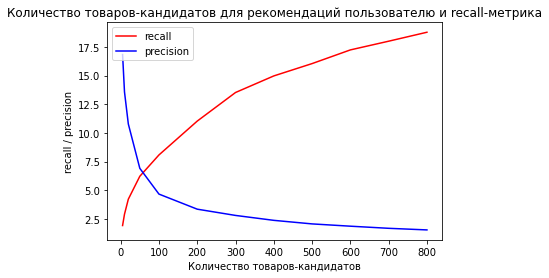

In [17]:
result_list = np.array(result_list)
plt.plot(result_list[:,0],result_list[:,1],c='r', label = 'recall')
plt.plot(result_list[:,0],result_list[:,2],c='b', label = 'precision')
plt.title('Количество товаров-кандидатов для рекомендаций пользователю и recall-метрика')
plt.xlabel('Количество товаров-кандидатов')
plt.ylabel('recall / precision')
plt.legend(loc="upper left")
plt.show()

##### Выбор количества товаров-кандидатов для рекомендаций может быть основан на результатах выше проведенного подбора:
- на участке от 0 до 100 recall и precision находятся почти на одном уровне; выше 100 recall почти монотонно увеличивается, а precision с меньшей скоростью, но тоже почти монотонно уменьшается.
- Вначале был выбран вариант на уровне перекреста двух показателей: от 50 до 75 кандидатов; результаты были "не очень".
- Далее производилась проверка соседних результатов: при увеличении кол-ва кандидатов показатель precision на последнем этапе (проверка целевой выборки) увеличивался;
- Было выяснено, что максимальный результат получается при N = 250; поэтому были проверены самые близкие к этому варианту показатели - и выбрано N=244.
- После этого продолжена оптимизация гиперпараметров алгоритма LightGDM.
- в самом конце подобран параметр K в файле recommenders для функции fit_own_recommender: лучшим вариантом оказался K=12.

**повторное исполнение кода для сохранения кандидатов в датафрейм**

In [18]:
result_lvl_1['preds'] = ''
N_k=244
# 244
top_N = data_train_lvl_1.groupby('item_id').count()['quantity'].reset_index().sort_values('quantity',ascending=False)[1:].head(int(N_k*0.52))['item_id'].values
for user in set(result_lvl_1['user_id']):
    if user in data_train_lvl_1.user_id.values:
        x = []
        x.append(recommender.get_own_recommendations(user,N=int(N_k*0.48)))
#         x.append(recommender.get_als_recommendations(user,N=int(N_k*0.1)))
        x.append(top_N)
        x = list(np.hstack(x))
        result_lvl_1.loc[result_lvl_1['user_id']==user,'preds'] = result_lvl_1.loc[result_lvl_1['user_id']==user,'preds'].apply(lambda y: x)
print(f'recall = {recall_at_k(result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"preds"].tolist(),result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"actual"].tolist(), k = N_k)},precision = {precision_at_k(result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"preds"].tolist(),result_lvl_1.loc[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.values),"actual"].tolist(), k = N_k)}')

recall = 12.558139895347267,precision = 3.145125027627263


### Задание 2.

#### Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

---

### Кроме добавления новых фичей вначале произведено преобразование имеющихся данных:
- обработано поле **curr_size_of_product**: получены данные о мере измерения товара (литры, штука, унции, граммы и т.д.), которые могут, например, отражать удобство для покупателя (литр кока-колы в карман положить сложнее, чем 100 грамм мыла); кроме этого, некоторые вещи (например, лекарства даже с одинаковым названием) могут продаваться в разном аггрегатном состоянии; возможно, это имеет значение для принятия решения о покупке;
- из того же поля получены данные о количестве приобретенного товара;
- данные о доходах
- данные о возрасте
- созданы новые параметры, также как и на первом этапе: цена с учетом скидок, группа по отношениям к квантилям для цены, количествам покупок, номеру недели и времени транзакции;
- создан параметр "количество покупок" в каждой категории (department): sum_q_dep
- большинство из созданных параметров не нашли применения в модели LightGDM; лучшими же, нашедшими применение в этом алгоритме, оказались:
    - количество покупок в категориях (sum_q_dep),
    - квантиль-группа по времени транзакции (trans_time_q),
    - цена с учетом скидок (price_disc).


**По заданию:**
   - о товаре созданы 2 фичи: количество (ранг) и меры измерения;
   - о пользователе созданы фичи: возраст (ранг) и уровень дохода (ранг), цена приобретения с учетом скидки, количестов приобретенных товаров в каждой категории, отношение к различным квантиль-категориям по цене покупки, количеству покупок, номеру недели и времени транзакции; также пререаботано отношение к различным категориям по уровню дохода, средняя стоимость покупок (mean_sales_value).
   - фичи по парам групп параметров, характеризиующих пользователя и товар: цена товара с учетом скидки, количество продаж * цену товара с учетом дохода пользователя (sales_quantity_income), цена покупки товара с учетом дохода пользователя (sale_income)

In [19]:
# создается список пользователей из реальных данных о покупках, использованных ранее для проверки релевантности списка товаров-кандидатов
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']
# такой же список создается из данных, использованных ранее для создания списков товаров-кандидатов
train_users = data_train_lvl_1['user_id'].unique()
# тут добиваемся того, чтобы сохранились только те пользователи, которых были в data_train_lvl_1, т.е. попали в train_users
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]
# подготавливаем столбец в датафрейме для списка товаров-кандидатов для имеющегося списка пользователей
candidates_list = []
for i in users_lvl_2['user_id']:
#     в итоге: можем сохранить этот список (индивидуальный для каждого пользователя) в только что созданный столбец
    x = result_lvl_1.loc[result_lvl_1['user_id']==i,'preds'].values[0]
    candidates_list.append(x)
users_lvl_2['candidates']  = candidates_list

# для дальнейшей работы нужно "раскрыть" списки для каждого пользователя
# т.к. ранее была выбрана тактика выбрать 50 товаров-кандидатов для каждого пользователя, то в датафрейме получится 50 строк для каждого пользователя
df = users_lvl_2.explode('candidates').explode('candidates')
# переименуем столбцы для того, чтобы потом работать с другими датафреймами
df.columns = ['user_id','item_id']
df.head()

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,882826
0,2070,950202
0,2070,878715


In [20]:
# итак, раз у нас уже есть реальный список купленных товаров, то мы можем создать из него датафрейм для того,
# чтобы в соседнем столбце для каждого товара указать, что он куплен
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1
# теперь список купленных товаров можно объединить со списком рекомендованных товаров
# те товары, которые совпали с уже купленными, окажутся в той же самой строке и получат признак "куплен" (т.е. рекомендация была верной)
targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
# если же товар не нашел себе "пару" в датафрейме с информацией о реально купленных товарах, то в столбце, информирующем о совершенной покупке будет проставлен "ноль"
targets_lvl_2['target'].fillna(0, inplace= True)
# targets_lvl_2[targets_lvl_2['target']==0]

# укажем долю угаданных купленных товаров: в общем-то, не так много; надо с этим что-то делать!
targets_lvl_2['target'].mean()

0.04683193516360752

In [21]:
# пришло время объединить всю имеющуюся информацию в один датафрейм: объединим информацию о покупках с информацией о самих товарах и пользователях
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

# targets_lvl_2.head(2).T

**из имеющихся данных, подобно первому этапу работы, создадим дополнительные расчетные поля**
##### описание - в начале раздела

In [22]:
data_train_lvl_2['price'] = data_train_lvl_2['sales_value'] / data_train_lvl_2['quantity']
data_train_lvl_2['price'].fillna(0)
data_train_lvl_2['price'] = data_train_lvl_2['price'].replace([np.inf, -np.inf], 0)
data_train_lvl_2['quantity_q'] = pd.cut(data_train_lvl_2['quantity'],bins = data_train_lvl_2['quantity'].quantile([0,0.7,0.9,0.985,1]),labels=[1,2,3,4])
data_train_lvl_2['week_no_q'] = pd.cut(data_train_lvl_2.week_no,bins=data_train_lvl_1.week_no.quantile([0,0.25,0.5,0.75,1]).values,labels=[1,2,3,4]).fillna(1)
data_train_lvl_2['price_q'] = pd.cut(data_train_lvl_2.price,bins=data_train_lvl_1.price.quantile([0,0.25,0.5,0.75,1]).values,labels=[1,2,3,4]).fillna(1)
data_train_lvl_2['trans_time_q'] = pd.cut(data_train_lvl_2.trans_time,bins=data_train_lvl_1.trans_time.quantile([0,0.25,0.5,0.75,1]).values,labels=[1,2,3,4]).fillna(1)
data_train_lvl_2['price_disc'] = data_train_lvl_2['price']-data_train_lvl_2['retail_disc']*data_train_lvl_2['price']

targets_lvl_2 = targets_lvl_2.merge(data_train_lvl_2, on=['user_id', 'item_id'], how='left', copy=False)
targets_lvl_2.head().T

,0,1,2,3,4
user_id,2070,2070,2070,2070,2070
item_id,1105426,1097350,882826,950202,878715
target,0.0,0.0,0.0,0.0,0.0
manufacturer,69,2468,69,69,697
department,DELI,GROCERY,DELI,DELI,GROCERY
brand,Private,National,Private,Private,National
commodity_desc,SANDWICHES,DOMESTIC WINE,SANDWICHES,SANDWICHES,BEERS/ALES
sub_commodity_desc,SANDWICHES - (COLD),VALUE GLASS WINE,SANDWICHES - (COLD),SANDWICHES - (COLD),BEERALEMALT LIQUORS
curr_size_of_product,,4 LTR,,,12 OZ
age_desc,45-54,45-54,45-54,45-54,45-54


**обращает внимание на себя обилие незаполненных значений для более, чем половины параметров**

In [23]:
# работа с отсутствующими данными; в некоторых случаях логика подсказывает,
# что было бы неплохо взять среднее или наиболее часто встречающееся значение,
# но эксперименты показали,что во многих случаях лучше подставить "ноль"
targets_lvl_2['day'].fillna(0,inplace=True)
targets_lvl_2['quantity'].fillna(0,inplace=True)
targets_lvl_2['retail_disc'].fillna(0,inplace=True)
targets_lvl_2['sales_value'].fillna(0,inplace=True)
targets_lvl_2['coupon_disc'].fillna(0,inplace=True)
targets_lvl_2['coupon_match_disc'].fillna(0,inplace=True)
targets_lvl_2['marital_status_code'].fillna(0,inplace=True)
targets_lvl_2['kid_category_desc'].fillna(0,inplace=True)
targets_lvl_2['trans_time'].fillna(0,inplace=True)
targets_lvl_2['week_no_q'].fillna(4,inplace=True)
targets_lvl_2['price_q'].fillna(1,inplace=True)
targets_lvl_2['trans_time_q'].fillna(4,inplace=True)
targets_lvl_2['week_no'].fillna(targets_lvl_2['week_no'].mean(),inplace=True)
# для остальных полей используем средние показатели для кждой группы marital_status_code/household_size_desc:
# очевидно, что структура расходов и объем покупок зависит от размера семьи
a = targets_lvl_2.groupby('marital_status_code')['trans_time'].mean()
for k,i in enumerate(a):
    targets_lvl_2.loc[(targets_lvl_2['trans_time'].isna()) & (targets_lvl_2['marital_status_code']==a.index[k]),'trans_time'] = i

a = targets_lvl_2.groupby('marital_status_code')['price'].mean()
for k,i in enumerate(a):
    targets_lvl_2.loc[(targets_lvl_2['price'].isna()) & (targets_lvl_2['marital_status_code']==a.index[k]),'price'] = i

a = targets_lvl_2.groupby('household_size_desc')['price'].mean()
for k,i in enumerate(a):
    targets_lvl_2.loc[(targets_lvl_2['price'].isna()) & (targets_lvl_2['household_size_desc']==a.index[k]),'price'] = i

a = targets_lvl_2.groupby('household_size_desc')['coupon_match_disc'].mean()
for k,i in enumerate(a):
    targets_lvl_2.loc[(targets_lvl_2['coupon_match_disc'].isna()) & (targets_lvl_2['household_size_desc']==a.index[k]),'coupon_match_disc'] = i
    

a = targets_lvl_2.groupby(['marital_status_code','kid_category_desc'],as_index=False)['quantity'].mean()
targets_lvl_2['quantity_ML_mean']=0
for k,i in enumerate(a):
    targets_lvl_2.loc[(targets_lvl_2['marital_status_code']==a.marital_status_code[k]) & (targets_lvl_2['kid_category_desc']==a.kid_category_desc[k]),'quantity_ML_mean'] = a.quantity[k]


targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,week_no,coupon_disc,coupon_match_disc,price,quantity_q,week_no_q,price_q,trans_time_q,price_disc,quantity_ML_mean
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,88.439064,0.0,0.0,3.291949,NaN,4,1,4,NaN,0.0
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,...,88.439064,0.0,0.0,3.291949,NaN,4,1,4,NaN,0.0
2,2070,882826,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,88.439064,0.0,0.0,3.291949,NaN,4,1,4,NaN,0.0
3,2070,950202,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,88.439064,0.0,0.0,3.291949,NaN,4,1,4,NaN,0.0
4,2070,878715,0.0,697,GROCERY,National,BEERS/ALES,BEERALEMALT LIQUORS,12 OZ,45-54,...,88.439064,0.0,0.0,3.291949,NaN,4,1,4,NaN,0.0


**Создание тренировочной части датафрейма**:
- X_train будет содержать информацию о товарах и пользователях,
- y_train - метки о том, куплен был товар или нет (1 и 0).

In [24]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2['target']

In [25]:
# после создания X_train, работы с отсутствующими данными -
# продолжение работы с данными: создание новых полей
X_train['sum_q_dep'] = X_train.groupby(['user_id','department'])['quantity'].count().reset_index()['quantity']
# добавление нового поля **mean_sales_value**
X_train['mean_sales_value'] = X_train.groupby(['user_id','brand'])['sales_value'].count().reset_index()['sales_value']
X_train['mean_sales_value'].fillna(0,inplace=True)
X_train['sum_q_dep'].fillna(0,inplace=True)
X_train['retail_disc_q'] = pd.cut(X_train['retail_disc'],X_train['retail_disc'].quantile([0,0.005,0.01,0.015,1]),labels=[1,2,3,4])
X_train.head()

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,...,price,quantity_q,week_no_q,price_q,trans_time_q,price_disc,quantity_ML_mean,sum_q_dep,mean_sales_value,retail_disc_q
0,2070,1105426,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,...,3.291949,NaN,4,1,4,NaN,0.0,25.0,252.0,4
1,2070,1097350,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,...,3.291949,NaN,4,1,4,NaN,0.0,18.0,38.0,4
2,2070,882826,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,...,3.291949,NaN,4,1,4,NaN,0.0,153.0,208.0,4
3,2070,950202,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,...,3.291949,NaN,4,1,4,NaN,0.0,25.0,35.0,4
4,2070,878715,697,GROCERY,National,BEERS/ALES,BEERALEMALT LIQUORS,12 OZ,45-54,U,...,3.291949,NaN,4,1,4,NaN,0.0,27.0,199.0,4


**Обработка категориальных данных**

In [26]:
%%time
X_train['item_measure'] = ''
X_train['curr_size_of_product'] = X_train['curr_size_of_product'].astype('str')
check_list = [['Weight','LB','CTN','CT','LOAD','LBS','BAG','LD'],['Length','GA','FT'],
              ['Volume','ML','GALLON','GAL','OZ','QT','PK','PINT','LTR','LITRE'],['square','SQ FT','SQFT'],
              ['items','COUNT','DOZEN','DZ','OUNCE','PT','CUBE','STEM','SHEETS','BTL','CAN','LNNR','PACK','KIT','ROLLS']]
for i in check_list:
    for ii in i:
        X_train.loc[X_train['curr_size_of_product'].str.contains(ii),'item_measure'] = i[0]

# X_train['item_measure'].value_counts()

CPU times: user 6.95 s, sys: 0 ns, total: 6.95 s
Wall time: 6.96 s


- **В ячейке выше выполнена попытка разбить товары по мерам измерения (объем, масса, количество штук, площадь)**
- **В ячейке ниже - попытаемся получить данные о количестве товара в упаковке или партии при покупке.**

In [27]:
%%time
X_train['curr_size_of_product'].to_csv('curr_size_of_product.csv')
# следующая команда d pyhton выполняется очень долго, поэтому ниже приведен код для командной строки для использования потокового редактора sed
#X_train['curr_size_of_product'] = [X_train.loc[X_train['item_measure']==i,'curr_size_of_product'].values[0].split(i)[0] if len(i)>0 else 1 for i in X_train.loc[:,'item_measure']]

# код для командной строки - выполняется за несколько секунд; предварительно создайте пустой файл curr_size_of_product1.csv, доступный для записи
!sed 's/\([0-9]*\),\([0-9,.\ ]*\)\([\ ]*\)\([\,]*[\ ]*[a-z]*[A-Z]*[0-9]*\)/\1,\2/' curr_size_of_product.csv > curr_size_of_product1.csv
# в результате в файле curr_size_of_product1.csv сохранен числа, соответствующие кол-ву товара в единицах,
# которые мы сохранили в столбце item_measure
# правда, с некоторыми ошибками;

# теперь заменим значения столбца полу-очищенными данными ("полу-очищенными", т.к. там хватает ошибок, но они уже не помешают);
X_train['curr_size_of_product'] = pd.read_csv('curr_size_of_product1.csv')['_size_of_product']
# есть ошибки обработки, но тут важен только порядок числа; в ячейках с ошибками, как правило, порядок чисел = 10^1 или меньше;
# X_train['curr_size_of_product'].value_counts()[:20]

CPU times: user 880 ms, sys: 47.5 ms, total: 927 ms
Wall time: 2.87 s


In [28]:
%%time
# при анализе обнаружилось, что снова появились отсутствующие данные!
# замена пустых значений в столбце item_measure и curr_size_of_product
# если мера измерения не указана (или была потеряна в процессе обработки данных), попытаемся использовать "item" (т.е. "количество штук")
X_train.loc[X_train['item_measure']=='','item_measure'] = 'item'
# если количество продаваемого товара не указано (или было потеряно при обработке данных), предположим, что продают по 1 единице
X_train.loc[X_train['curr_size_of_product']=='','curr_size_of_product'] = 1
# остальные значения заполним "рангами" способом: данные условно разобьем на "до 10", "от 10 до 100" и т.п. и заменим реальные значения данной оценкой в виде порядковых номеров
replace_list = []
for i in X_train['curr_size_of_product']:
    try:
        if int(i)<=10:
            replace_list.append(1)
        elif int(i)<=100:
            replace_list.append(2)
        elif int(i)<=1000:
            replace_list.append(3)
        elif int(i)>1000:
            replace_list.append(4)
        else:
            replace_list.append(2)
#             если же i содержит непонятный набор знаков (м.б. буквы остались, например), то заменим значение на 2
    except Exception:
        replace_list.append(2)
X_train['curr_size_of_product'] = replace_list

# X_train['item_measure'].value_counts()

CPU times: user 937 ms, sys: 30.5 ms, total: 967 ms
Wall time: 970 ms


##### Проверка заполненности информации о возрасте пользователей

In [29]:
X_train['age_desc'].value_counts()

45-54    79561
35-44    53256
25-34    39378
65+      18828
55-64    15871
19-24    12278
Name: age_desc, dtype: int64

In [30]:
# упорядоченными номерами "разметим" возрастные группы пользователей
X_train.loc[X_train['age_desc']=='19-24','age_desc'] = 1
X_train.loc[X_train['age_desc']=='25-34','age_desc'] = 2
X_train.loc[X_train['age_desc']=='35-44','age_desc'] = 3
X_train.loc[X_train['age_desc']=='45-54','age_desc'] = 4
X_train.loc[X_train['age_desc']=='55-64','age_desc'] = 5
X_train.loc[X_train['age_desc']=='65+','age_desc'] = 6
# в незаполненные ячейки подставим значение, соответствующее (по личному опыту) среднему возрасту активных онлайн-покупателей
X_train['age_desc'].fillna(3,inplace=True)
# наиболее частыми значениями восстановим пропущенные данные в других столбцах
X_train['department'].fillna(X_train['department'].mode()[0],inplace=True)
X_train['brand'].fillna(X_train['brand'].mode()[0],inplace=True)
X_train['commodity_desc'].fillna(X_train['commodity_desc'].mode()[0],inplace=True)
X_train['sub_commodity_desc'].fillna(X_train['sub_commodity_desc'].mode()[0],inplace=True)
# категории детских товаров
X_train['kid_category_desc'] = X_train['kid_category_desc'].astype('str')
X_train.loc[X_train['kid_category_desc']=='0','kid_category_desc'] = 1
X_train.loc[X_train['kid_category_desc']=='1','kid_category_desc'] = 2
X_train.loc[X_train['kid_category_desc']=='2','kid_category_desc'] = 3
X_train.loc[X_train['kid_category_desc']=='3+','kid_category_desc'] = 4
X_train.loc[X_train['kid_category_desc']=='None/Unknown','kid_category_desc'] = 0


In [31]:
# тут все в порядке
X_train['marital_status_code'].value_counts()

0    343555
U     93968
A     93139
B     32065
Name: marital_status_code, dtype: int64

In [32]:
# проверим, что данные у нас введены "правильно"; например, попробуем присвоить тип int  всему столбцу; если есть ошибка (если там есть буква, например) - это не получится сделать.
X_train['curr_size_of_product'] = X_train['curr_size_of_product'].astype(int)
X_train['age_desc'] = X_train['age_desc'].astype(int)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 562727 entries, 0 to 562726
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   user_id               562727 non-null  int64   
 1   item_id               562727 non-null  object  
 2   manufacturer          562727 non-null  int64   
 3   department            562727 non-null  object  
 4   brand                 562727 non-null  object  
 5   commodity_desc        562727 non-null  object  
 6   sub_commodity_desc    562727 non-null  object  
 7   curr_size_of_product  562727 non-null  int64   
 8   age_desc              562727 non-null  int64   
 9   marital_status_code   562727 non-null  object  
 10  income_desc           219172 non-null  object  
 11  homeowner_desc        219172 non-null  object  
 12  hh_comp_desc          219172 non-null  object  
 13  household_size_desc   219172 non-null  object  
 14  kid_category_desc     562727 non-nul

In [33]:
# посмотрим на столбец с информацией об уровне доходов
X_train['income_desc'].value_counts()

50-74K       52623
35-49K       46244
75-99K       26334
25-34K       20723
15-24K       19483
Under 15K    15438
125-149K     10963
100-124K      9414
150-174K      9232
250K+         4043
175-199K      3366
200-249K      1309
Name: income_desc, dtype: int64

In [34]:
# заменим такие неудобные данные на слова (очень низкий - низкий - средний - высокий), заодно объединив их в более крупные группы
X_train.loc[:,'income_desc'] = X_train.loc[:,'income_desc'].astype('str')
X_train.loc[X_train['income_desc'].isin(['Under 15K','15-24K']),'income_desc']=1
X_train.loc[X_train['income_desc'].isin(['25-34K','35-49K','50-74K']),'income_desc']=2
X_train.loc[X_train['income_desc'].isin(['75-99K','100-124K','125-149K','150-174K','175-199K']),'income_desc']=3
X_train.loc[X_train['income_desc'].isin(['200-249K','250K']),'income_desc']=4
X_train.loc[X_train['income_desc']=='nan','income_desc'] = 2
X_train.loc[X_train['income_desc']=='250K+','income_desc'] = 5

In [35]:
# заменим пропущенные данные на 0
X_train['quantity'].fillna(0,inplace=True)
# сгенерируем некоторые дополнительные параметры; изначально их эффект не был известен, но в процессе работы они помогли выявить некоторые закономерности;
# в конечной модели они не участвовали
X_train['sale_income'] = X_train['income_desc'].astype('int') * X_train['sales_value'].astype('int')
X_train['sales_quantity'] = X_train['quantity'] * X_train['sales_value']
X_train['sales_quantity_income'] = X_train['sales_quantity'].astype('int') * X_train['income_desc'].astype('int')
X_train['sale_income'].fillna(0,inplace=True)
X_train['sales_quantity_income'].fillna(0,inplace=True)
X_train['sale_income'] = X_train['sale_income'].fillna(0).astype('int')
X_train['sales_quantity_income'] = X_train['sales_quantity_income'].fillna(0).astype('int')
X_train.quantity_ML_mean = X_train.quantity_ML_mean.astype('int')

####################################################################################
#######переходим к формированию интересующих списков параметров#####################
# сохраним в списки те столбцы, которые хотим сохранить в категориальном виде; остальные - оставим как есть
cat_feats = ['department','brand','manufacturer','commodity_desc','sub_commodity_desc','curr_size_of_product','age_desc','marital_status_code','income_desc',
             'homeowner_desc','hh_comp_desc','household_size_desc','kid_category_desc','item_measure','quantity_q','retail_disc_q']
feats = ['price_disc','quantity','sales_value','retail_disc','coupon_disc','coupon_match_disc','sale_income','sales_quantity','sales_quantity_income','day',
         'trans_time','week_no','sum_q_dep','mean_sales_value','trans_time_q','price_q','week_no_q','price','quantity_ML_mean']
# все столбцы - в одном списке
columns = cat_feats + feats
# данные cat_feats переведем в тип category
X_train[cat_feats] = X_train[cat_feats].astype('category')

In [36]:
# стандартизация
std_sc = StandardScaler()
X_train[feats] = std_sc.fit_transform(X_train[feats])

lgb = LGBMClassifier(bagging_freq = 7,pos_bagging_fraction = 0.1, neg_bagging_fraction = 0.1, boosting = 'gbdt', silent=True,reg_lambda = 0.1, random_state = 0,objective='binary', categorical_column=cat_feats,bagging_fraction = 0.15, learning_rate =  0.37, max_depth = 2, n_estimators = 28)
# вручную подбираем столбцы для анализа: подбор осуществялся с помощью GridSearchCV и его best_params_
# названия параметров, записанные в "минус" имели вес = 0; дальнейшее удаление параметров приводило к значимому ухудшению прогноза
columns_ = set(columns)-{'sale_income','income_desc','age_desc','price_q','item_measure','retail_disc_q','quantity_ML_mean','curr_size_of_product','household_size_desc','kid_category_desc','manufacturer','price','quantity','retail_disc','sales_value','coupon_disc','coupon_match_disc','sales_quantity_income','sales_quantity','week_no_q','week_no','trans_time','day'}
lgb.fit(X_train[columns_], y_train.values.tolist());
train_preds = lgb.predict_proba(X_train[columns_])[:,1]
# train_preds

/home/andreyl/Soft/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.15, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


In [37]:
pd.DataFrame(lgb.feature_importances_,columns_)

,0
brand,10
marital_status_code,0
trans_time_q,7
sum_q_dep,8
hh_comp_desc,0
mean_sales_value,0
quantity_q,24
price_disc,1
commodity_desc,0
sub_commodity_desc,5


In [38]:
# в X_train добавим информацию о том, какие товары были реально куплены (ее мы выносили в отдельный массив y_train)
# и вероятности, с которыми мы предсказываем, купит ли пользователь этот товар или нет
X_train['real'] = y_train
X_train['recommendation'] = train_preds
# Признак "recommendation" содержит предсказание в виде вероятности, что пользователь купит товар
# Необходимо скорректировать эту вероятность, с учетом неучтенных в модели факторов:
# так, очевидно, что если пользователь покупал что-то в за довольно большую цену, то вероятность, что это ему действительно нужно, должна быть выше
## (мы же не платим дорого за то, что нам не нужно!)
# в то же время, если время транзакции занимает много времени, то вероятность того,
## что пользователю пришлось подумать (и м.б. ему это не так уж нужно????) растет
# если же пользователь покупал много такого товара, значит ему его много нужно - вероятность должна бы быть выше
## а если он пользуется только купоном, м.б. не стоит ему это предлагать: не купит, пока купона нет
# то же самое с параметром "продажи-доход" (sale_income): выяснилось экспериментальным путем,
## что если множитель продажи*группу дохода растет, то вероятность покупки падает
# применено стандартное возведение параметров в квадрат для избавления от отрицательных значений после стандартизации
X_train['recommendation'] = (X_train['recommendation']**2) * (X_train['mean_sales_value']**2) * (1/X_train['trans_time_q']**2) * (X_train['quantity']**2) * (1/X_train.coupon_disc**2) * (1/X_train['sale_income']**2)**(1/2)
X_train_preds = X_train[['user_id','item_id','real','recommendation']]
# для сохранения окончательных результатов и получения оценки precision@k создадим еще один датафрейм results
results = pd.DataFrame(columns = ['user_id','item_id','recommendation'])
# и сохраним в нем только 100 наиболее вероятно купленных товаров (отсортированы по убыванию вероятности)
for i in X_train_preds.user_id.unique():
    results = results.append(X_train_preds.loc[X_train_preds['user_id']==i,['user_id','item_id','recommendation']].nlargest(100,'recommendation'), ignore_index=True)
# проведем объединение всех 100 рекомендованных для каждого пользователя товаров в один список
# после этого в одной строке - один пользователй - 100 рекомендованных для него товаров с наибольшей вероятностью покупки
# (отсортированы от максимума к минимуму методом nlargest())
results = results.groupby(results.user_id)['item_id'].unique().reset_index()
# теперь можно объединить в одном датафрейме 100 наиболее вероятно купленных товаров и реальо купленные товары
results['target'] = targets_lvl_2[['user_id','item_id']].groupby(targets_lvl_2.user_id)['item_id'].unique().reset_index()['item_id']
# results.head()

### Все готово для того, чтобы проверить релевантность наших рекомендаций

##### Проверка на тренировочной выборке

In [39]:
%%time
recall = recall_at_k(results['item_id'],results['target'], k = 5)
print(f'recall@5 = {round(recall,2)}%')

precision = precision_at_k(results['item_id'],results['target'], k = 5)
print(f'precision@5 = {round(precision,2)}%')

recall@5 = 2.08%
precision@5 = 99.88%
CPU times: user 4.51 s, sys: 1.67 ms, total: 4.51 s
Wall time: 4.52 s


### Проверка на тестовой выборке

In [40]:
check_df = pd.DataFrame(data_val_lvl_2[['user_id','item_id']].groupby(data_val_lvl_2.user_id)['item_id'].unique()).reset_index()[['user_id','item_id']]
check_df.columns = ['user_id','check']
results_df = results.merge(check_df,on='user_id',how='right')
results_df.loc[results_df.item_id.isna(),'item_id'] = results_df.loc[results_df.item_id.isna(),'item_id'].apply(lambda x: [0])
precision = precision_at_k(results_df['item_id'],results_df['check'], k = 5)
print(f'precision@5 = {round(precision,2)}%')

precision@5 = 26.67%


In [41]:
users = data_val_lvl_2.user_id.unique()
data_val_test = data_val_lvl_1.copy()
data_val_test = data_val_test.merge(targets_lvl_2, on = ['user_id','item_id'], how = 'outer')

data_val_test['day'] = data_val_test[['day_x','day_y']].min(axis=1)
data_val_test['quantity'] = data_val_test[['quantity_x','quantity_y']].min(axis=1)
data_val_test['sales_value'] = data_val_test[['sales_value_x','sales_value_y']].min(axis=1)
data_val_test['store_id'] = data_val_test[['store_id_x','store_id_x']].min(axis=1)
data_val_test['retail_disc'] = data_val_test[['retail_disc_x','retail_disc_y']].min(axis=1)
data_val_test['trans_time'] = data_val_test[['trans_time_x','trans_time_y']].min(axis=1)
data_val_test['week_no'] = data_val_test[['week_no_x','week_no_y']].min(axis=1)
data_val_test['coupon_disc'] = data_val_test[['coupon_disc_x','coupon_disc_y']].min(axis=1)
data_val_test['coupon_match_disc'] = data_val_test[['coupon_match_disc_x','coupon_match_disc_y']].min(axis=1)
data_val_test.drop(['quantity_x','quantity_y','sales_value_x','sales_value_y','store_id_x','store_id_y','retail_disc_x','retail_disc_y','trans_time_x',
                   'trans_time_y','week_no_x','week_no_y','coupon_disc_x','coupon_disc_y','coupon_match_disc_x','coupon_match_disc_y','day_x','day_y'],axis=1,inplace=True)

a = data_val_test.groupby('marital_status_code')['trans_time'].mean()
for k,i in enumerate(a):
    data_val_test.loc[(data_val_test['trans_time'].isna()) & (data_val_test['marital_status_code']==a.index[k]),'trans_time'] = i

a = data_val_test.groupby('marital_status_code')['price'].mean()
for k,i in enumerate(a):
    data_val_test.loc[(data_val_test['price'].isna()) & (data_val_test['marital_status_code']==a.index[k]),'price'] = i

a = data_val_test.groupby('household_size_desc')['price'].mean()
for k,i in enumerate(a):
    data_val_test.loc[(data_val_test['price'].isna()) & (data_val_test['household_size_desc']==a.index[k]),'price'] = i

a = data_val_test.groupby('household_size_desc')['coupon_match_disc'].mean()
for k,i in enumerate(a):
    data_val_test.loc[(data_val_test['coupon_match_disc'].isna()) & (data_val_test['household_size_desc']==a.index[k]),'coupon_match_disc'] = i
    
a = data_val_test.groupby(['marital_status_code','kid_category_desc'],as_index=False)['quantity'].mean()
data_val_test['quantity_ML_mean']=0
for k,i in enumerate(a):
    data_val_test.loc[(data_val_test['marital_status_code']==a.marital_status_code[k]) & (data_val_test['kid_category_desc']==a.kid_category_desc[k]),'quantity_ML_mean'] = a.quantity[k]

data_val_test['day'].fillna(targets_lvl_2['day'].mean(),inplace=True)
data_val_test['quantity'].fillna(1,inplace=True)
data_val_test['retail_disc'].fillna(0,inplace=True)
data_val_test['sales_value'].fillna(0,inplace=True)
data_val_test['coupon_disc'].fillna(0,inplace=True)
data_val_test['coupon_match_disc'].fillna(0,inplace=True)
data_val_test['marital_status_code'].fillna('U',inplace=True)
data_val_test['kid_category_desc'].fillna('None/Unknown',inplace=True)
data_val_test['trans_time'].fillna(data_val_test['trans_time'].mean(),inplace=True)
data_val_test['week_no_q'].fillna(1,inplace=True)
data_val_test['price_q'].fillna(1,inplace=True)
data_val_test['trans_time_q'].fillna(1,inplace=True)
# data_val_test['week_no'].fillna(0,inplace=True) - в данном случае не нужный параметр

# как и в самом начале, применим фильтр для выбора 5000 самых популярных товаров, которые еще есть смысл рекомендовать
data_val_test = prefilter_items(data_val_test, item_features=item_features, take_n_popular=5000)
a = data_val_test['sales_value'] / data_val_test['quantity']
data_val_test['price'] = a - a*data_val_test['coupon_disc']-a*data_val_test['retail_disc']
data_val_test['price'].fillna(0)
data_val_test['price'] = data_val_test['price'].replace([np.inf, -np.inf], 0)
data_val_test['week_no_q'] = pd.qcut(data_val_test.week_no,q=2,labels=[1,2]).fillna(1)
data_val_test['price_q'] = pd.qcut(data_val_test.price,q=2,labels=[1,2]).fillna(1)
data_val_test['trans_time_q'] = pd.qcut(data_val_test.trans_time,q=2,labels=[1,2]).fillna(1)
data_test = data_val_test.append(data_train_lvl_1)
recommender2 = MainRecommender(data_test)

# в этой части кода создается датафрейм с данными о купленных товарах по каждому пользователю
result_test_sales = data_test.groupby('user_id')['item_id'].unique().reset_index()
result_test_sales.columns=['user_id', 'actual']
result_test_sales = result_test_sales.explode('actual').merge(result_lvl_1[['user_id','actual']].explode('actual'),how='inner',on='actual')[['actual','user_id_y']]
result_test_sales.columns = ['actual','user_id']
# применен аналогичный первому этапу подход: большая доля top_popular, остальное - own_recommendations
top_N = data_val_test.groupby('item_id').count()['quantity'].reset_index().sort_values('quantity',ascending=False)[1:].head(3)['item_id'].values
for user in set(results_df['user_id'].values):
    N_k=5
    if len(results_df.loc[results_df.user_id==user,'item_id'].values[0])<N_k:
        if user in data_test.user_id.values:
            x=[]
            x.append(top_N)
            x.append(recommender2.get_own_recommendations(user,N=N_k))
            
            x=list(np.hstack(x))
            results_df.loc[results_df['user_id']==user,'item_id'] = results_df.loc[results_df['user_id']==user,'item_id'].apply(lambda y: x)
precision = precision_at_k(results_df['item_id'],results_df['check'], k = 5)
print(f'precision@5 = {precision}%')

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/6800 [00:00<?, ?it/s]

precision@5 = 27.002938295788326%


In [44]:
# формат предоставления отчета в задани не задан, поэтому сохраним все 3 поля:
# рекомендации, target для тренировочной групп, check - данные тестовой группы.
# precision рекомендаций подсчитан выше
results_df.to_csv('results_df.csv')
results_df

,user_id,item_id,target,check
0,1,"[1082185, 1082269, 8091601, 9655212, 940947, 8...","[856942, 9297615, 5577022, 877391, 1088462, 96...","[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[1029743.0, 1075368.0, 1106523.0, 7410071.0, 1...",NaN,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[1082185, 897088, 1098844, 12757544, 1024306, ...","[13003092, 13002975, 923600, 875306, 1084036, ...","[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[1082185, 1106523, 1126899, 1122358, 909714, 9...","[998519, 894360, 6552318, 832473, 1123106, 714...","[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[1082185, 1029743, 1044078, 6034857, 1068719, ...","[12808385, 939860, 872826, 956689, 977927, 921...","[835098, 872137, 910439, 924610, 992977, 10412..."
...,...,...,...,...
2037,2496,"[1082185, 995965, 1106523, 916122, 899624, 933...","[872826, 956689, 7442505, 983665, 873160, 9068...",[6534178]
2038,2497,"[1029743, 1070820, 1010950, 824759, 1081177, 1...","[870515, 1102207, 1117219, 869835, 1089618, 91...","[1016709, 9835695, 1132298, 16809501, 845294, ..."
2039,2498,"[1070820, 1100379, 1106523, 993638, 1045710, 1...","[1022066, 1012801, 849578, 1076580, 5574108, 9...","[15716530, 834484, 901776, 914190, 958382, 972..."
2040,2499,"[1070820, 5568378, 5569327, 1081177, 1060872, ...","[7168055, 1128395, 6904613, 1081533, 847962, 1...","[867188, 877580, 902396, 914190, 951590, 95813..."


### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 0.27%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 